# 5장 서포트 벡터 머신

**서포트벡터머신**(SVM)  
- 선형이나 비선형 분류, 회귀, 이상치 탐색에도 사용할 수 있는 다목적 머신러닝 모델
- 머신러닝에서 가장 인기 있는 모델중 하나  
- 복잡한 분류모델에 잘 맞고, 작거나 중간 크기의 데이터 셋에 적합


## 5.1 선형 SVM 분류

- 왼쪽 그래프는 두 분류의 데이터를 선형 분류 한 것  
선형으로 완벽하게 분류된것처럼 보이지만 결정경계가 샘플에 너무 가까워 새로운 데이터에 잘 작동할지는 의문.  
- 오른쪽 그래프는 SVM 분류기의 결정 경계. 이 직선은 두 개의 크래스를 나누고 있을 뿐만 아니라 제일 가까운 훈련 샘플로 부터 가능한한 멀리 떨어져있다.  
다시말해 SVM 분류기는 두 클래스 사이에 가장 폭이 넓은 도로를 찾는 것으로 생각할 수 있다. 이를 **라지마진분류**라고한다.

도로 바깥쪾(그러니까 점선 바깥쪽)에 새로운 샘플을 추가해도 결정 경계에는 영향을 미치지않는다. (실선 결정경계에서 가장 가까운 데이터만이 결정경계 형성에 영향을 미침) 이러한 샘플을 **서포트 벡터**라고한다.

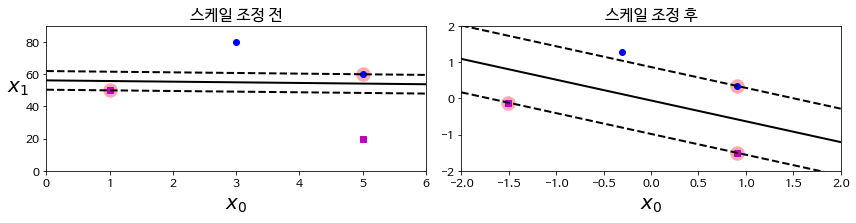

*`Caution`   
SVM은 특성의 스케일에 민감하다. 왼쪽 그래프에서는 수직축의 스케일이 수평축의 스케일보다 훨씬 커서 가장 넓은 도로가 거의 수평에 가깝게 된다. 특성의 스케일을 조정하면 결정 경계가 훨씬 좋아진다.*

#### 5.1.1 소프트 마진 분류

모든 샘플이 도로 바깥쪽에 올바르게 분류되어있다면 __하드 마진 분류__ 라고 함.  
하드 마진 분류의 문제점 
1. 데이터가 선형적으로 구분될 수 있어야 제대로 작동한다.
2. 이상치에 민감하다.

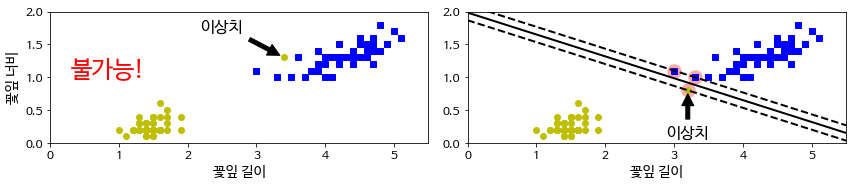

왼쪽 그래프와 같이 이상치가 있는 경우 하드마진을 찾을 수 없다.  
오른쪽 그래프의 결정경계는 이상치가 없던 결정경계과 매우 다르고 일반화가 잘 되지 않을 것 같다.

이 문제를 해결하기위해 좀 더 유연한 모델이 필요하다. 도로의 폭을 가능한 한 넓게 유지하는 것과 __마진 오류__ 사이에 적절한 균형을 잡아야한다. 이를 __소프트마진분류__라 한다.

사이킷런 SVM 모델에서는 C 하이퍼파라미터를 사용해 이 균형(도로의 폭을 가능한한 넓게 유지하는것 <-> 마진 오류)을 조절할 수 있다.  
C↓ -> 도로의 폭↑, 마진 오류↑  
C↑ -> 도로의 폭↓, 마진 오류↓

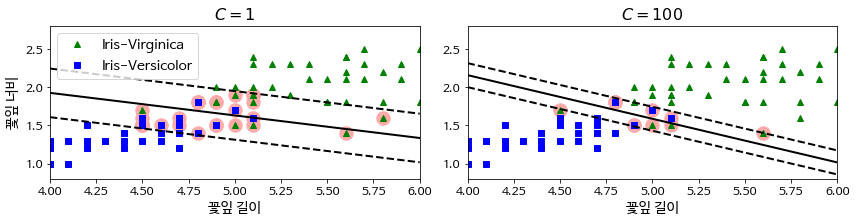

C가 100일때는 마진오류를 적게 냈지만 마진이 좁아졌다.  
C가 1일때는 마진이 넓어졌지만 많은 샘플이 도로안에 포함 되었다.  
즉 C가 1일떄 일반화는 더 잘된것 처럼 보인다. 

_SVM 모델이 과대적합이 의심된다면 C를 감소시켜 모델을 규제할 수 있다_

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] ##petal length, petal width
y = (iris['target'] ==2).astype(np.float64) #Iris-Virginica

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state = 42)), 
])

svm_clf.fit(X,y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=4, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [3]:
svm_clf.predict([[5.5, 1.7]]) #즉 Iris-Virginica로 예측

array([1.])

`주의할것`  
linearSVC와 SVC(kernel = "linear") 은 명백히 다름.  
SVC(kernel = "linear")은 큰 훈련셑에서 속도가 매우 느리므로 권장하지않는다  
SGDClassifier(loss="hinge", alpha = 1/(m*C)) 와 같은 모델을 사용할 수도 있다. 이는 선형 SVM 분류기를 훈련시키기외해 호가률적 경사하강법을 적용한다. LienarSVC만큼 빠르게 수렴하지는 않지만 데이터셋이 아주 커서 메모리에 적재할수 없거나 온라인 학습으로 문제를 다룰때는 유용하다

`Tip`______ __SVC(kernel = "linear")에 상응하는 LienarSVC의 설정__ 
1. 규제에 편향을 포함시키므로 훈련세트에서 평균을 빼서 중앙에 맞춰야한다. StandardScaler를 사용하면된다.
2. loss 매개변수를 "hinge"로 지정해야한다.
3. 훈련 샘플보다 특성이 많지않다면 성능을 높이기위해 dual 매개변수를 False로 지정해야한다.

## 5.2 비선형 SVM 분류

선형 SVM은 효율적이고 잘 작동하지만 선형적으로 분류할 수 없는 데이터 셋이 있다.  
비선형 데이터셋을 다루는 한가지 방법은 다항 특성과 같은 특성을 추가하는 것.  
사이킷런의 PolynomialFeatures변환기와 StandardScaler, LinearSVC를 연결하여 Pipeline을 만들면 좋다.  

In [7]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X,y = make_moons(n_samples = 100, noise = 0.15, random_state =42)

polynomial_svc_clf = Pipeline([
    ("poly_feaures", PolynomialFeatures(degree = 3)),
    ("scaler", StandardScaler()),
    ("svc_clf", LinearSVC(C=10, loss="hinge", max_iter = 2000))
])

polynomial_svc_clf.fit(X,y)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('poly_feaures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=2000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

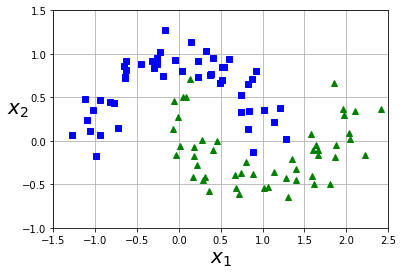

In [11]:

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

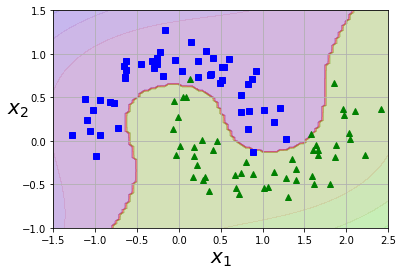

In [13]:
import matplotlib.pyplot as plt
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svc_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

### 5.2.1 다항식 커널

- 다항식 특성을 추가하는 것은 간단하고 모든 머신러닝 알고리즘에서 잘 작동함
- 낮은 차수의 다항식은 매우 복잡한 데이터셋을 잘 표현하지 못함
- 높은 차수의 다항식은 굉장히 많은 특성을 추가하므로 모델을 느리게 만듬
- SVM은 커널트릭이라는 기적에 가까운 수학적 기교를 적용할 수 있음

In [18]:
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel = "poly", degree = 3, coef0 = 1, C=5))

])
poly_kernel_svm_clf.fit(X,y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=1, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [19]:
poly100_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel = "poly", degree = 10, coef0 = 100, C=5))

])
poly100_kernel_svm_clf.fit(X,y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=100, decision_function_shape='ovr', degree=10,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

3차 다항식 커널을 사용해 SVM 분류기를 훈련.  
과대/과소적합 여부를 판단하여 차수를 높일지 낮출지 판단

poly100의 경우 과적합

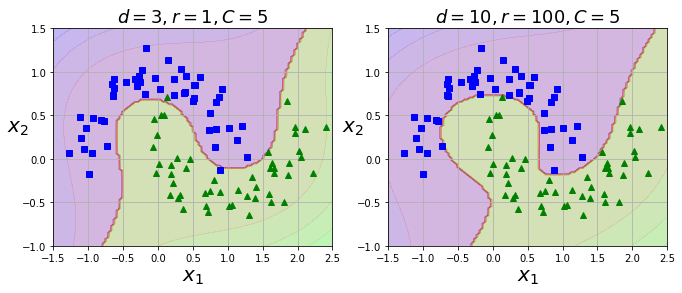

In [20]:
plt.figure(figsize=(11,4)) ##figure size 지정

plt.subplot(121) # subplot1
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X,y,[-1.5,2.5,-1,1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize = 18)

plt.subplot(122) # subplot2
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X,y,[-1.5,2.5,-1,1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize = 18)

plt.show()

### 5.2.2 유사도 특성 추가

비선형 특성을 다루는 또 다른 기법은 각 샘플이 특정 __랜드마크__ 와 얼마나 닮았는지를 측정하는 __유사도 함수__로 계산한 특성을 추가하는 것이다.

예를들어 앞서 본 1차원 데이터셋에 두 개의 랜드마크 $X_1 = -2 와 X_1 =1$ 을 추가한다.  
그리고 $\gamma = 0.3$ 인 가우시안 __방사 기저 함수 (RBF)__를 유사도 함수로 정의하자

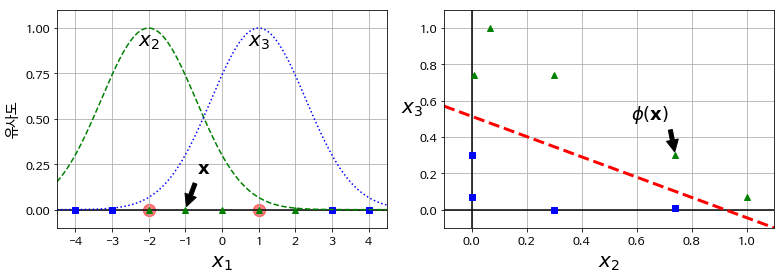

그러면 랜드마크를 어떻게 선택할까? 간단한 방법은 데이터셋에 있는 모든 샘플 위치에 랜드마크를 설정하는 것이다. 이때 장점과 단점?
- 장점 : 차원이 매우커지고 따라서 변환된 훈련세트가 선형적으로 구분될 가능성이 높다.
- 단점 : 훈련세트에 있는 n개의 특성을 가진 m개의 샘플이 m개의 m개의 샘플로 변환 된다는 것이다. 즉, 훈련 세트가 매우 클경우 동일한 크기의 아주 많은 특성이 만들어진다.

### 5.2.3 가우시안 RBF 커널

다항 특성 방식과 마찬가지로 __유사도 특성 방식__ 도 머신러닝 아로리즘에 유용하게 사용될 수 있다. 추가 특성을 모두 계산하려면 연산 비용이 많이 드는데 특히 훈련세트가 클 경우 더 그렇다.  
_하지만, 커널 트릭이 한 번 더 SVM의 마법을 만듭니다_  
유사도 특성을 많이 추가하는것과 같은 비슷한 결과를 실제로 특성을 추가하지 않고 얻을 수 있다.

__SVC 모델에 가우시안 RBF 커널을 적용__

In [21]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X,y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

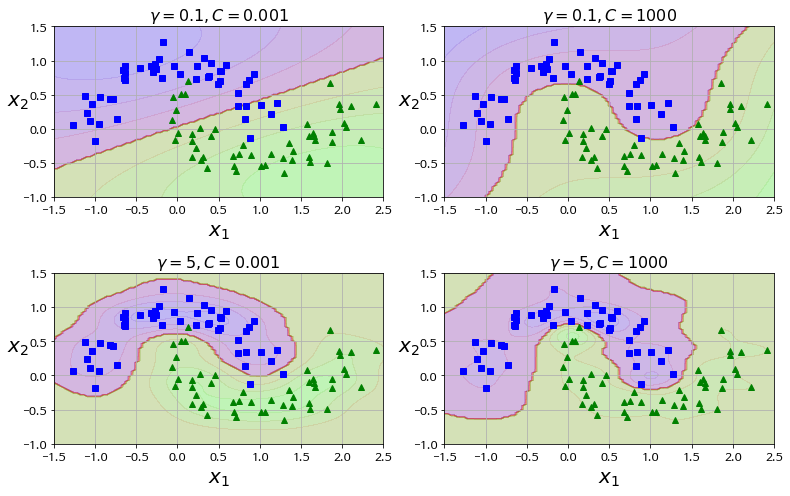

위는 rbf커널에서 파라미터를 바꿨을때 결정경계의 변화이다. $\gamma$ 값을 증가시키면 종 모양의 그래프가 좁아진다. 
반대로 $\gamma$값을 줄이면 넓은 종모양의 그래프를 만들며 샘플이 넓은 범위에 걸쳐 영향을 주므로 결정 경계가 더 부드러워진다.  
결국 하이퍼파리미터 $\gamma$가 규제의 역할을 한다.  
_모델이 과대적합일 경우엔 감소시켜야하고 과소적합일 경우엔 증가시켜야한다_

```그러면 어떤 커널을 써야할까?```

경험적으로 봤을때 언제나 선형 커널을 가장 먼저 시도해봐야한다.  
(LinearSVC가 SVC(kernel="linear")보다 훨씬 빠르다는것을 잊지말자.)  
특히 훈련세트가 아주 크거나 특성 수가 많을 때 더 그렇다.  
훈련 세트가 너무 크지 않다면 가우시안 RBF 커널을 시도해보면 좋다. 대부분의 경우에는 이 커널이 잘 들어맞다.

### 5.2.4 계산 복잡도

- LinearSVC는 선형 SVM을 위한 최적화된 알고맂므을 구현한 liblinear 라이브러리를 기반으로한다. 이 라이브러리는 커널 트릭을 지원하지 않지만 훈련 샘플과 특성 수에 거의 선형적으로 늘어난다. 이 알고리즘의 훈련 복잡도는 $O(m \times n)$ 정밀도를 높이면 알고리즘 수행 시간이 길어진다. 이는 허용오차 하이퍼 파라미터 $\epsilon$으로 조절한다(sklearn의 tol = 0.0001),  
__대부분의 분류문제는 허용오차를 기본값으로 두면 잘 작동한다.__

- SVC는 커널 트릭 알고리즘을 구현한 libsvm 라이브러리를 기반으로 한다. 훈련시간 복잡도는 $O(m^2 \times n)$ ~ $O(m^3 \times n)$ 즉, 훈련 샘플수가 커지면 엄청나게 느려진다는 것을 의미한다. 복잡하지만 작거나 중간규모의 훈련세트에는 잘 맞아떨어진다. 하지만 특성의 개수에는, 특히 희소특성인 경우에는 잘 확장된다

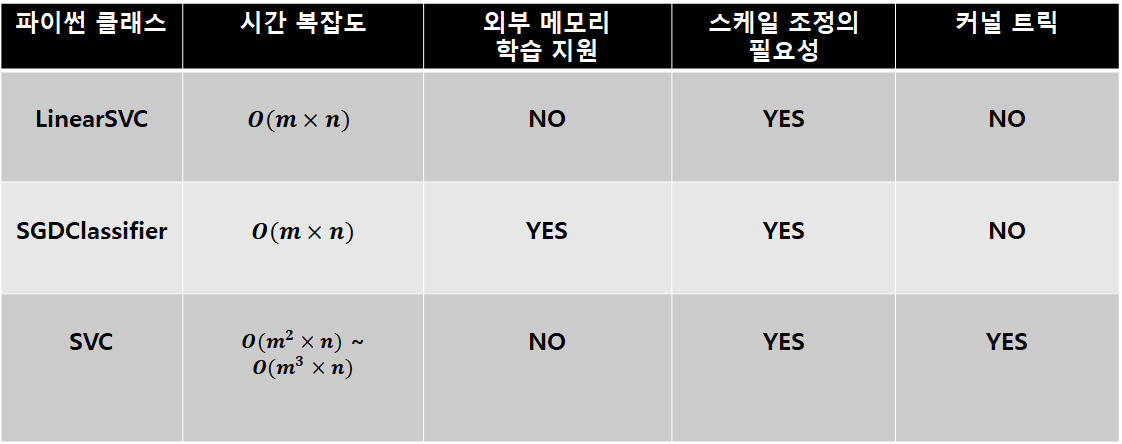

## 5.3 SVM 회귀

SVM을 회귀에 적용하는 방법은 목표를 반대로하는것이다.  
일정한 마진 오류 안에서 클래스 간의 도로 폭이 가능 한 최대가 되도록 하는 대신. __SVM회귀는 제한된 마진 오류 안에서 도로안에 가능한한 많은 샘플이 드러가도록 학습한다__  
도로의 폭은 $\epsilon$ 으로 조절하면된다.

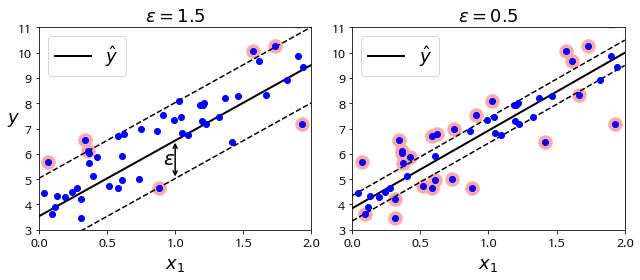

마진 안에서는 훈련샘플이 추가되어도 모델의 예측에는 별 영향이 없다.  
즉, __$\epsilon$에 민감하지 않다__ 

In [22]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon = 1.5)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [23]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", gamma = 'auto', degree = 2, C=100, epsilon = 0.1)
svm_poly_reg.fit(X,y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

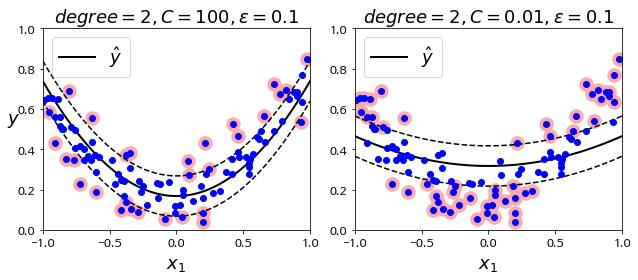

-파라미터 크기에 따른 SVR-  
- cf. SVR은 SVC의 회귀 버전이고 LinearSVR은 LinearSVC의 회귀버전이다. LinearSVR은 LinearSVC처럼 필요한 시간이 훈련 세트의 크기에 비례해서 선형적으로 늘어난다. 하지만 SVR은 훈련세트가 커지면 훨씬 느려진다.

## SVM 이론